# Business Understanging

**Objetivo do Dataset**
O cliente, no caso a COPPE/Poli/UFRJ apresenta uma base de dados que consiste em diversas séries temporais de alta amostragem de sinais de vibração de motores, onde foram simulados desalinhamentos horizontais e verticais, com o objetivo de reproduzir o comportamento de motores que gradativamente ficam defeituosos. Os analistas responsáveis pelo projeto são: Bruno Leal Fonseca e Guilherme Namen Pimenta, ambos igualmente responsáveis pelo andamento do projeto como um todo. O resultado do trabalho será usado para avaliar/monitorar a saúde de ativos de motores 
elétricos, alertando de possíveis danos causados no equipamento. 

Usar algoritmos de agrupamento, para conseguir segmentar regimes de operação nominal de motores elétricos dos regimes defeituosos, usando sinais de vibração dos rotores. Estabelecendo fronteiras entre os níveis aceitáveis e críticos dos equipamentos, para fazer manutenções com gastos minimizados. 

**Origem dos Dados**
O dataset foi desenvolvido pela equipe da Universidade Federal do Rio de Janeiro (UFRJ) e está disponível no portal do Grupo de Monitoramento e Diagnóstico de Sistemas Mecânicos (MDS). As medições foram realizadas em um motor com um rotor a 50 kHz e armazenadas em diferentes categorias com base nos tipos e severidades das falhas introduzidas.

**Características do Dataset**
- Estrutura do Dataset: O conjunto de dados está organizado em pastas que representam diferentes condições de falha, como desalinhamento horizontal e vertical, desequilíbrio, e condições normais. Subpastas indicam níveis de severidade específicos (exemplo: 0.5 mm de desalinhamento).

- Os dados consistem em várias planilhas CSV, cada uma delas apresenta os seguintes atributos:

    - tachometer: Medição do tacômetro.
    - underhang_1, underhang_2, underhang_3: Vibrações em sensores posicionados no lado inferior.
    - overhang_1, overhang_2, overhang_3: Vibrações em sensores posicionados no lado superior.
    - microphone: Medição de som/vibração ao redor do motor.

    - Linhas: Representam instantes de tempo durante a coleta de dados. No caso a amostragem foi feita a 50 kHz. Considerando que o registro durou 5 segundos, foram obtidas 250.000 amostras por registro. No total há cerca de 40 desses registros para cada tipo de estado dos motores.

**Relação com o Problema de Negócio**
Este dataset é relevante para o diagnóstico de falhas e a manutenção preditiva de sistemas industriais. A detecção de anomalias com base em medições de vibração pode:

1. Prevenir falhas catastróficas: Identificar tendências de falhas antes que elas ocorram.
2. Reduzir custos de manutenção: Implementar estratégias baseadas na condição real do motor, evitando manutenções desnecessárias.
3. Melhorar a eficiência operacional: Garantir o funcionamento contínuo e otimizado de sistemas industriais.
4. Redução de gastos com falhas inesperadas: Quando um motor falha, há grandes despesas para substituição parcial ou total do equipamento, além do prejuízo da produção ficar parada durante a inesperada manutenção e realocação de colaboradores

**Próximos Passos**
Com este entendimento inicial, podemos:

1. Primeiramente, será necessário reduzir um pouco o tamanho da base de dados, pelo fato de cada registro ser muito extenso e haverem diversos tipos de falhas que podem ocorrer, algumas delas serão simplificadas. As falhas do tipo Overhang e Underhang serão limitadas a apenas o tipo 'ball_fault'. Além disso, serão considerados os 3 piores cenários para cada tipo de falha.
2. Processar os dados para gerar atributos descritivos que capturam o comportamento vibracional do motor.
3. Aplicar algoritmos de agrupamento, como DBSCAN, para identificar padrões e possíveis anomalias.
4. Validar a eficácia do agrupamento utilizando os rótulos originais (normal e falhas), aplicando métricas de avaliação externas.

# Data Understanding & Data Preparation

A primeira coisa a ser feita é pensar como os dados devem ser tratados para os algoritmos de agrupamento. Como a base consiste em um número muito grande de registros, será feita uma engenharia de atributos para achar características que descrevem bem os sinais temporais. Usar os dados temporais provou-se ser muito ineficiente, pois mesmo falhas expressivas podem ser imperceptíveis no domínio do tempo.

Portanto, para cada planilha CSV foram extraídas características do sinal, depois todas elas são concatenadas em um único dataframe para ser levado à modelagem. Foram totalizadas 709 arquivos CSV (cada uma com 250.00 linhas), cada uma será tratada como um único registro no dataframe de atributos estimados.

Foi utilizada a Transformada Rápida de Fourrier (FFT), para extrair características do domínio da frequência, obtendo os harmônicos mais expressivos e suas frequências é possível descrever bem a vibração dos motores. Sinais temporais de alta amostragem, tal como vibração e corrente elétrica, tendem a ser bem consistentes, na presença de uma anomalia, os harmônicos tendem a deslocar ou mudar de módulo, também é possível que novos harmônicos apareçam indicando a falha. A imagem abaixo ilustra isso:

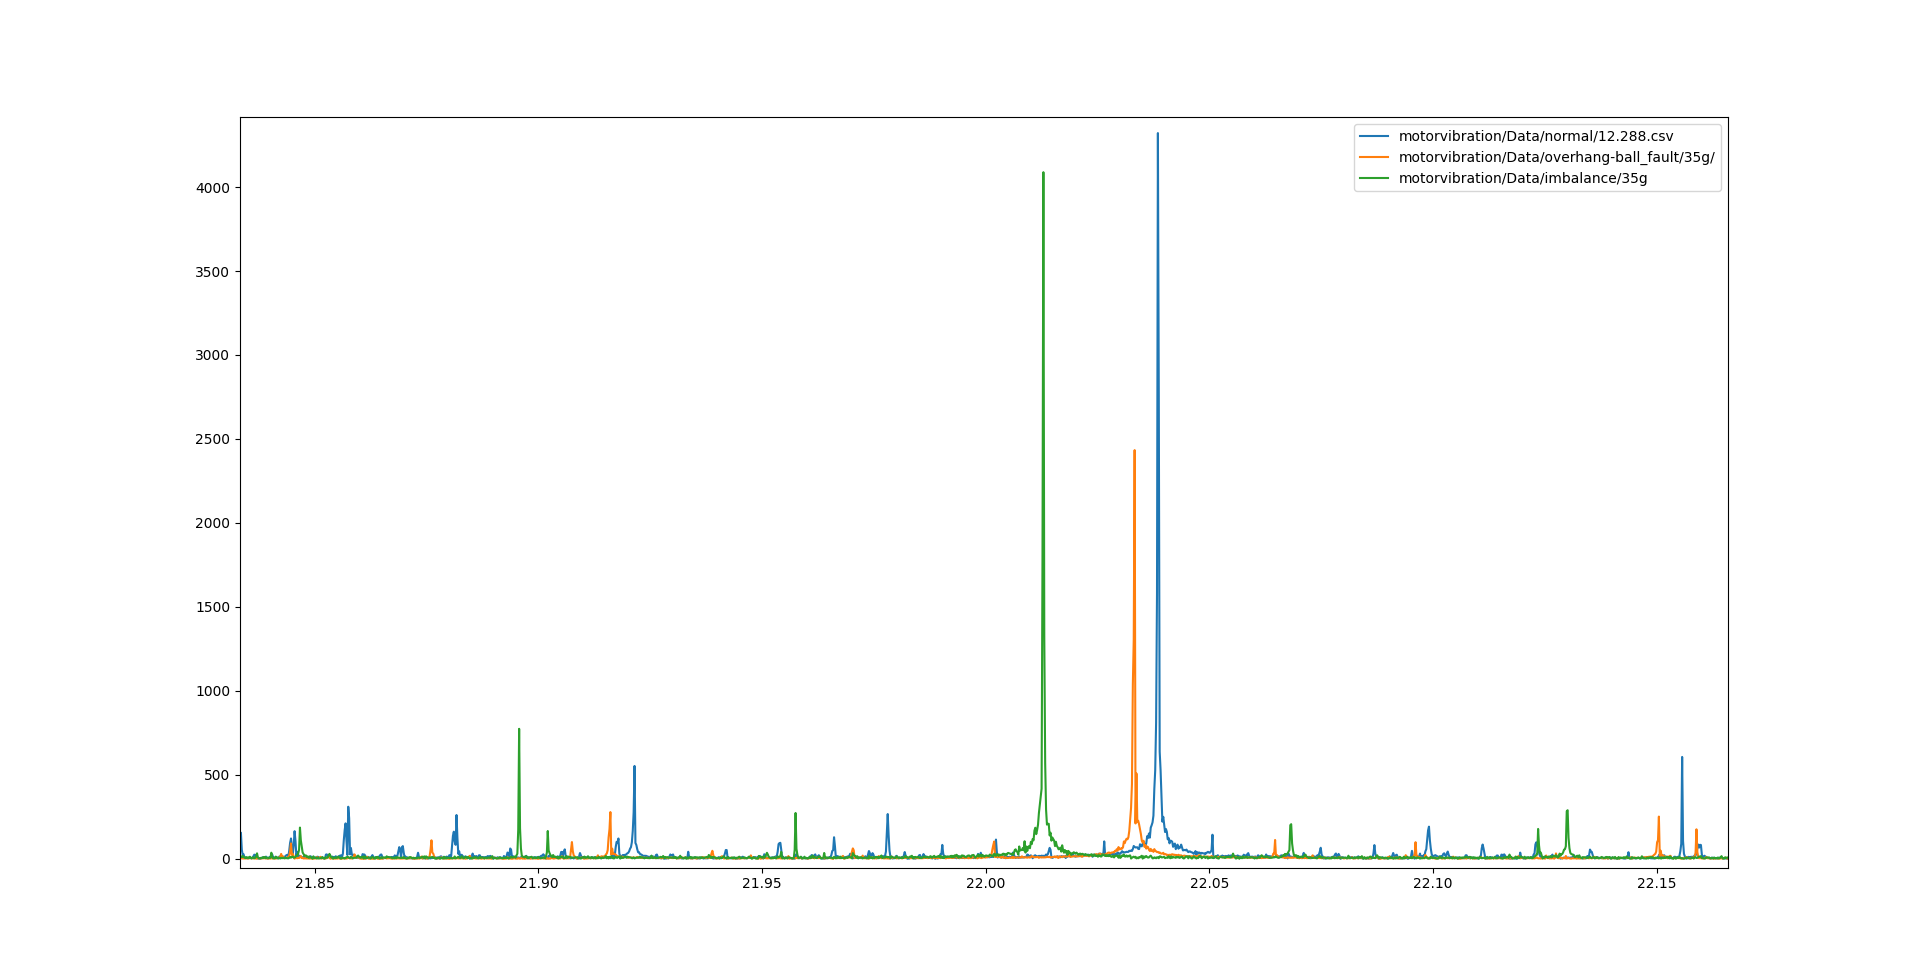

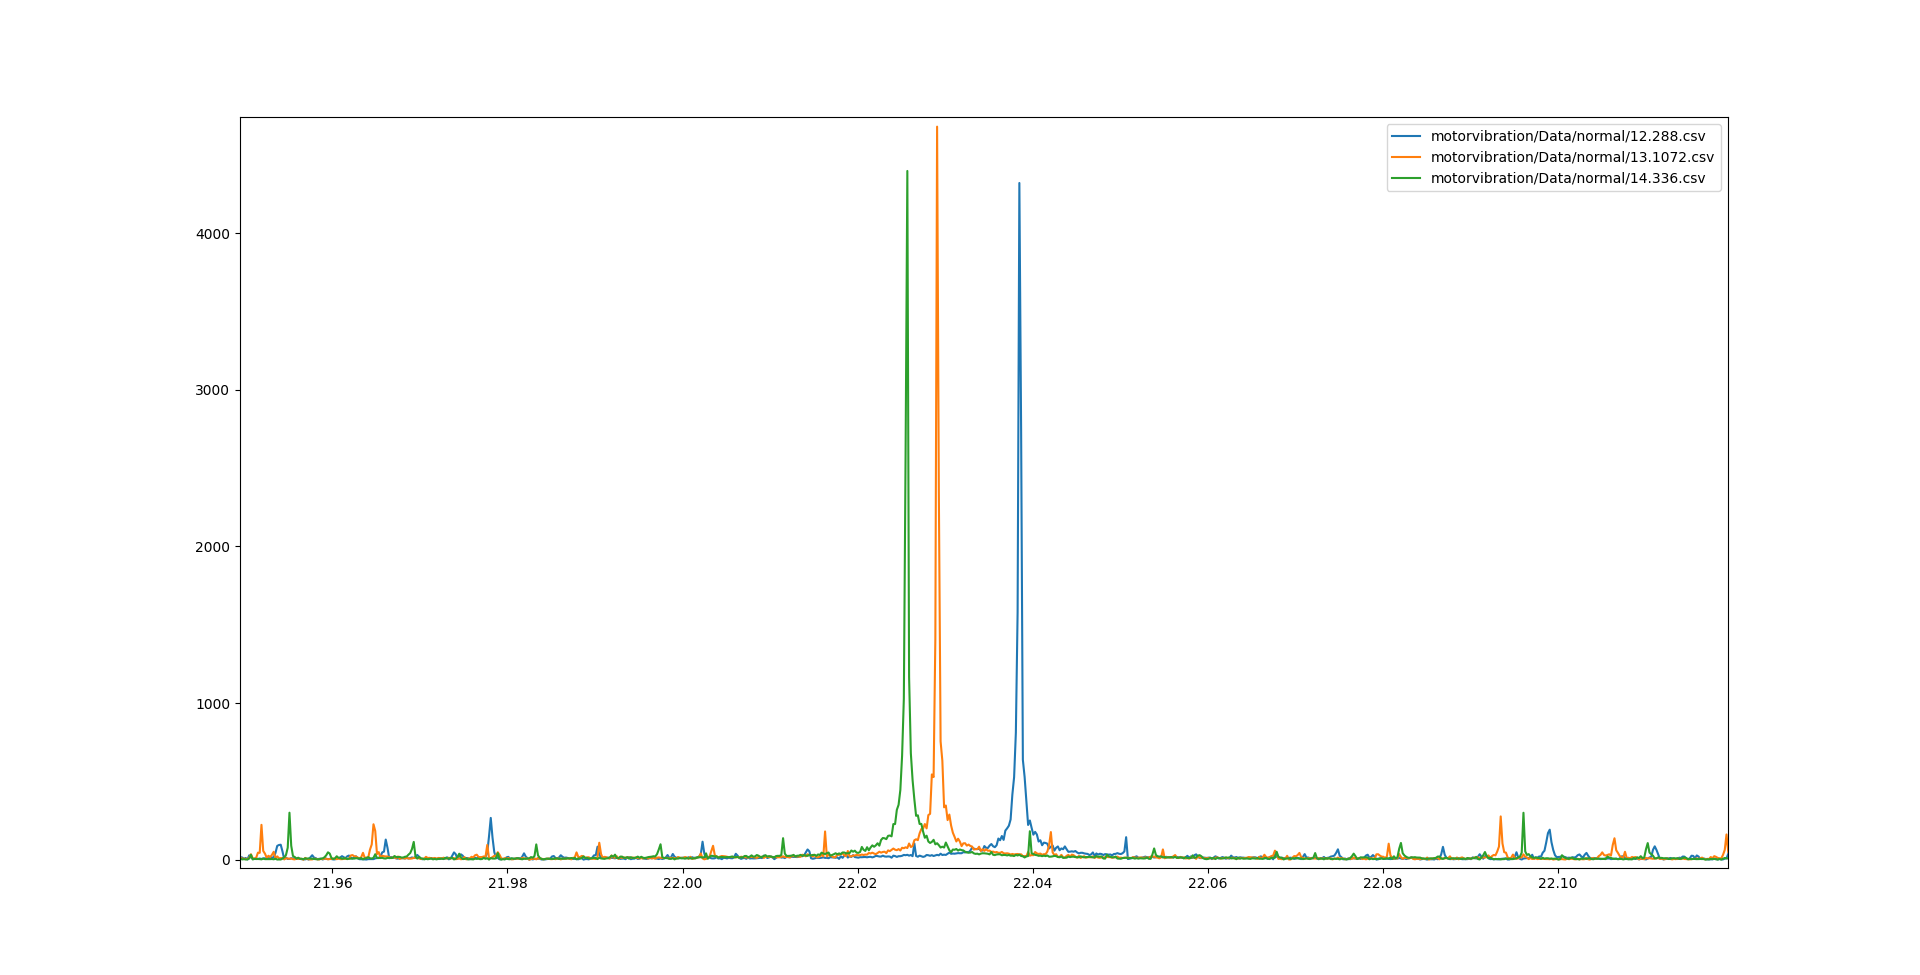

A base de dados original apresenta 8 colunas que foram medições de variáveis físicas por instrumentação, sendo duas delas o tacômetro medindo a velocidade e a outra o microfone medindo o ruído do rotor. 
Foram então selecionados os 500 harmônicos mais expressivos, pegando o módulo e frequência na qual ocorreram. Isso foi feito para cada uma das 8 colunas.

In [ ]:
def get_spectrum(self, p_y: np.ndarray) -> pl.DataFrame:
        yf = fftpack.fft(p_y)
        xf = fftpack.fftfreq(len(p_y), 1 / self.frequency_hz)
        spectrum_df = pl.DataFrame({"xf": xf, "yf": np.abs(yf)})

        return spectrum_df

def get_greatests_harmonics(self, p_df: pl.DataFrame, top_n: int, p_min_freq: float) -> pl.DataFrame:
    p_df = p_df.lazy().filter(pl.col("xf") > p_min_freq).collect()
    return p_df.sort(by="yf", descending=True).head(top_n)

def get_top_harmonics(
    self, p_name: str, p_df: pl.DataFrame, p_target_feature: str, p_freq_thresh: float, p_top_harmonics: int
) -> pl.DataFrame:
    spectrum_feat = {"file_name": p_name}
    spectrum_df = self.get_spectrum(p_df[p_target_feature].to_numpy())
    spectrum_df = self.get_greatests_harmonics(spectrum_df, p_top_harmonics, p_freq_thresh)

    for idx in range(p_top_harmonics):
        spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}_frequency"] = spectrum_df.row(idx, named=True)["xf"]
        spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}"] = spectrum_df.row(idx, named=True)["yf"]

    return pl.DataFrame(spectrum_feat)

[ADICIONAR EXPLICAÇÃO DA TRANSFORMADA WAVELET]

In [ ]:
def get_wavelet_features(self, p_signal: np.ndarray, p_target: str, p_wavelet="db2", p_levels=4):
    # Decompor o sinal em níveis usando DWT
    coeffs = pywt.wavedec(p_signal, p_wavelet, level=p_levels)

    features = {}

    # Para cada nível de decomposição (aproximação e detalhes)
    for i, coeff in enumerate(coeffs):
        # Estatísticas dos coeficientes
        features[f"{p_target}_level_{i}_mean"] = np.mean(coeff)
        features[f"{p_target}_level_{i}_std"] = np.std(coeff)
        features[f"{p_target}_level_{i}_energy"] = np.sum(coeff**2)
        features[f"{p_target}_level_{i}_kurtosis"] = np.mean((coeff - np.mean(coeff)) ** 4) / (np.std(coeff) ** 4)
        features[f"{p_target}_level_{i}_skewness"] = np.mean((coeff - np.mean(coeff)) ** 3) / (np.std(coeff) ** 3)

    return pl.DataFrame(features)

Também foram estimadas algumas estatísticas de básicas no domínio do tempo, são elas: 
- min
- max
- mean
- var
- kurtosis
- skewness
- entropy

Essas estatísticas podem ser muito úteis no agrupamento, pois nota-se que em cada planilha CSV o experimento foi diferente, os valores de velocidade do tacômetro e as vibrações se comportam de maneiras diferentes, indicando que o motor pode ter sido colocado para rotacionar em regimes variados, com essas estatísticas básicas, o agrupamento pode ganhar uma camada de robustez ao levar em conta uma representação direta das variáveis físicas.

In [ ]:
def get_stats_features(self, p_df: pl.DataFrame, p_target_feature: str) -> pl.DataFrame:
    feat_dict = {}

    df = p_df.with_columns(
        [
            pl.col(p_target_feature).min().alias("min"),
            pl.col(p_target_feature).max().alias("max"),
            pl.col(p_target_feature).mean().alias("mean"),
            pl.col(p_target_feature).var().alias("var"),
            pl.col(p_target_feature).kurtosis().alias("kurtosis"),
            pl.col(p_target_feature).skew().alias("skewness"),
            pl.col(p_target_feature).abs().entropy(base=2).alias("entropy"),
        ]
    )
    feat_dict[f"{p_target_feature}_min"] = df["min"][0]
    feat_dict[f"{p_target_feature}_max"] = df["max"][0]
    feat_dict[f"{p_target_feature}_mean"] = df["mean"][0]
    feat_dict[f"{p_target_feature}_var"] = df["var"][0]
    feat_dict[f"{p_target_feature}_kurtosis"] = df["kurtosis"][0]
    feat_dict[f"{p_target_feature}_skewness"] = df["skewness"][0]
    feat_dict[f"{p_target_feature}_entropy"] = df["entropy"][0]

    return pl.DataFrame(feat_dict)

O código completo do gerador de atributos segue abaixo:

In [ ]:
import os
from dataclasses import dataclass
from ast import literal_eval
from dotenv import load_dotenv
import numpy as np
import polars as pl
from scipy import fftpack
import pywt
import matplotlib.pyplot as plt


@dataclass
class FeatureEngineering:
    dataset: pl.DataFrame
    frequency_hz: float

    def filter_operations(self, p_df: pl.DataFrame, p_operations_list: list):
        filtered_df_list = []
        for operation in p_operations_list:
            df = p_df.lazy().filter(pl.col("file_name").str.contains(f"{operation}")).collect()
            filtered_df_list.append((df, operation))

        return filtered_df_list

    def plot_features(self, p_column: str, p_motor_operations: list):
        filterd_dataset = self.dataset[[p_column, "file_name"]]
        filterd_dataset_list = self.filter_operations(filterd_dataset, p_motor_operations)

        legend = []
        plt.figure()
        for operation_df, operation_name in filterd_dataset_list:
            plt.plot(operation_df[p_column])
            legend.append(operation_name)
        plt.legend(legend)
        plt.show()

    def get_wavelet_features(self, p_signal: np.ndarray, p_target: str, p_wavelet="db2", p_levels=4):
        # Decompor o sinal em níveis usando DWT
        coeffs = pywt.wavedec(p_signal, p_wavelet, level=p_levels)

        features = {}

        # Para cada nível de decomposição (aproximação e detalhes)
        for i, coeff in enumerate(coeffs):
            # Estatísticas dos coeficientes
            features[f"{p_target}_level_{i}_mean"] = np.mean(coeff)
            features[f"{p_target}_level_{i}_std"] = np.std(coeff)
            features[f"{p_target}_level_{i}_energy"] = np.sum(coeff**2)
            features[f"{p_target}_level_{i}_kurtosis"] = np.mean((coeff - np.mean(coeff)) ** 4) / (np.std(coeff) ** 4)
            features[f"{p_target}_level_{i}_skewness"] = np.mean((coeff - np.mean(coeff)) ** 3) / (np.std(coeff) ** 3)

        return pl.DataFrame(features)

    def get_spectrum(self, p_y: np.ndarray) -> pl.DataFrame:
        yf = fftpack.fft(p_y)
        xf = fftpack.fftfreq(len(p_y), 1 / self.frequency_hz)
        spectrum_df = pl.DataFrame({"xf": xf, "yf": np.abs(yf)})

        return spectrum_df

    def get_greatests_harmonics(self, p_df: pl.DataFrame, top_n: int, p_min_freq: float) -> pl.DataFrame:
        p_df = p_df.lazy().filter(pl.col("xf") > p_min_freq).collect()
        return p_df.sort(by="yf", descending=True).head(top_n)

    def get_top_harmonics(
        self, p_name: str, p_df: pl.DataFrame, p_target_feature: str, p_freq_thresh: float, p_top_harmonics: int
    ) -> pl.DataFrame:
        spectrum_feat = {"file_name": p_name}
        spectrum_df = self.get_spectrum(p_df[p_target_feature].to_numpy())
        spectrum_df = self.get_greatests_harmonics(spectrum_df, p_top_harmonics, p_freq_thresh)

        for idx in range(p_top_harmonics):
            spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}_frequency"] = spectrum_df.row(idx, named=True)["xf"]
            spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}"] = spectrum_df.row(idx, named=True)["yf"]

        return pl.DataFrame(spectrum_feat)

    def get_stats_features(self, p_df: pl.DataFrame, p_target_feature: str) -> pl.DataFrame:
        feat_dict = {}

        df = p_df.with_columns(
            [
                pl.col(p_target_feature).min().alias("min"),
                pl.col(p_target_feature).max().alias("max"),
                pl.col(p_target_feature).mean().alias("mean"),
                pl.col(p_target_feature).var().alias("var"),
                pl.col(p_target_feature).kurtosis().alias("kurtosis"),
                pl.col(p_target_feature).skew().alias("skewness"),
                pl.col(p_target_feature).abs().entropy(base=2).alias("entropy"),
            ]
        )
        feat_dict[f"{p_target_feature}_min"] = df["min"][0]
        feat_dict[f"{p_target_feature}_max"] = df["max"][0]
        feat_dict[f"{p_target_feature}_mean"] = df["mean"][0]
        feat_dict[f"{p_target_feature}_var"] = df["var"][0]
        feat_dict[f"{p_target_feature}_kurtosis"] = df["kurtosis"][0]
        feat_dict[f"{p_target_feature}_skewness"] = df["skewness"][0]
        feat_dict[f"{p_target_feature}_entropy"] = df["entropy"][0]

        return pl.DataFrame(feat_dict)

    def plot_spectrum(self, p_column: str, p_motor_operations: list, p_freq_thresh: float):
        filterd_dataset = self.dataset[[p_column, "file_name"]]
        filterd_dataset_list = self.filter_operations(filterd_dataset, p_motor_operations)

        legend = []
        _, ax = plt.subplots()

        for operation_df, operation_name in filterd_dataset_list:
            spectrum_df = self.get_spectrum(operation_df[p_column].to_numpy())
            spectrum_df = spectrum_df.lazy().filter(pl.col("xf") > p_freq_thresh).collect()

            ax.plot(spectrum_df["xf"], spectrum_df["yf"])
            legend.append(operation_name)
        plt.legend(legend)
        plt.show()

## Modeling

In [ ]:
from dataclasses import dataclass
import numpy as np
import polars as pl
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


@dataclass
class Model:
    dataset_path: str

    def filter_motor_operation(self, p_df: pl.DataFrame, p_name: str) -> pl.DataFrame:
        return p_df.lazy().filter(pl.col("file_name").str.contains(f"{p_name}")).collect()

    def filter_not_motor_operation(self, p_df: pl.DataFrame, p_name: str) -> pl.DataFrame:
        return p_df.lazy().filter(~pl.col("file_name").str.contains(f"{p_name}")).collect()

    def load_dataset(self):
        return pl.read_csv(self.dataset_path)

    def get_min_max_normalizer(self, p_df: pd.DataFrame) -> MinMaxScaler:
        return MinMaxScaler().fit(p_df)

    def normalize_data(self, p_df: pd.DataFrame):
        scaler = self.get_min_max_normalizer(p_df)
        return scaler, scaler.transform(p_df)

    def apply_normalizer(self, p_df: pd.DataFrame, p_scaler: MinMaxScaler):
        return p_scaler.transform(p_df)


if __name__ == "__main__":
    model = Model("motorvibration/Data/motor_vibration_dataset.csv")
    dataset = model.load_dataset()

    normal_operation_df = model.filter_motor_operation(dataset, "normal")
    normal_operation_df = normal_operation_df.with_columns(pl.lit(True).alias("normal_operation"))

    not_normal_operation_df = model.filter_not_motor_operation(dataset, "normal")
    not_normal_operation_df = not_normal_operation_df.with_columns(pl.lit(False).alias("normal_operation"))

    all_motor_operations_df = pl.concat([normal_operation_df, not_normal_operation_df])
    print(all_motor_operations_df)

    # Escolher os harmônicos e frequências para o scatter plot
    harmonic = 1
    x_column = f"overhang_3_harmonic_{harmonic}_frequency"
    y_column = f"overhang_3_harmonic_{harmonic}"

    # Criar scatter plot interativo
    fig = px.scatter(
        all_motor_operations_df,
        x=x_column,
        y=y_column,
        color="normal_operation",
        hover_data=["file_name"],
        title=f"Scatter Plot Interativo: {x_column} vs {y_column}",
        labels={"normal_operation": "Operação Normal"},
    )

    # Configurar layout do gráfico
    fig.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=0.5, color="DarkSlateGrey")))
    fig.update_layout(
        xaxis_title=x_column,
        yaxis_title=y_column,
        legend_title="Operação",
    )

    # Exibir o gráfico
    fig.show()

    training_data = all_motor_operations_df.drop(["file_name", "normal_operation"]).to_pandas()

    scaler, normal_data_scaled = model.normalize_data(
        normal_operation_df.drop(["file_name", "normal_operation"]).to_pandas()
    )
    training_data_scaled = model.apply_normalizer(training_data, scaler)

    print(scaler)
    print(normal_data_scaled.shape)

    kmeans = DBSCAN(eps=30.0)
    y_pred = kmeans.fit_predict(training_data_scaled)
    y_pred[y_pred == 0.0] = 1.0
    y_pred[y_pred == 2.0] = -1.0

    ari = adjusted_rand_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)
    nmi = normalized_mutual_info_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)
    v_measure = v_measure_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)

    print("Adjusted Rand Index (ARI):", ari)
    print("Normalized Mutual Information (NMI):", nmi)
    print("V-Measure:", v_measure)

    # Criar DataFrame para facilitar o uso com Plotly
    pca = PCA(n_components=2)
    reduced_data_3d = pca.fit_transform(training_data_scaled)

    plot_data = pd.DataFrame(reduced_data_3d, columns=["PCA1", "PCA2"])
    plot_data["Label"] = all_motor_operations_df["normal_operation"].to_numpy()

    # Plotar com Plotly
    fig = px.scatter(
        plot_data,
        x="PCA1",
        y="PCA2",
        # z="PCA3",
        color="Label",
        title="Anomalias Detectadas com GMM - PCA 3D",
        labels={"Anomaly": "É Anômalo", "Label": "Rótulo Original"},
        color_discrete_map={True: "blue", False: "red"},  # Cores para normal (azul) e anômalo (vermelho)
    )

    # Configurar layout
    fig.update_traces(marker=dict(size=6, opacity=0.8))
    fig.update_layout(scene=dict(xaxis_title="PCA1", yaxis_title="PCA2"))  # , zaxis_title="PCA3"))

    # Mostrar o gráfico
    fig.show()

    plot_data["Label"] = y_pred

    # Plotar com Plotly
    fig = px.scatter(
        plot_data,
        x="PCA1",
        y="PCA2",
        # z="PCA3",
        color="Label",
        title="Anomalias Detectadas com GMM - PCA 3D",
        labels={"Anomaly": "É Anômalo", "Label": "Rótulo Agrupamento"},
        color_discrete_map={True: "blue", False: "red"},  # Cores para normal (azul) e anômalo (vermelho)
    )

    # Configurar layout
    fig.update_traces(marker=dict(size=6, opacity=0.8))
    fig.update_layout(scene=dict(xaxis_title="PCA1", yaxis_title="PCA2"))  # , zaxis_title="PCA3"))

    # Mostrar o gráfico
    fig.show()
